## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from IPython.display import display

# import warnings
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv("/kaggle/input/earthquake-magnitude-damage-and-impact/csv_building_structure.csv")

In [3]:
df.head(2)

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             762106 non-null  int64 
 1   district_id                             762106 non-null  int64 
 2   vdcmun_id                               762106 non-null  int64 
 3   ward_id                                 762106 non-null  int64 
 4   count_floors_pre_eq                     762106 non-null  int64 
 5   count_floors_post_eq                    762106 non-null  int64 
 6   age_building                            762106 non-null  int64 
 7   plinth_area_sq_ft                       762106 non-null  int64 
 8   height_ft_pre_eq                        762106 non-null  int64 
 9   height_ft_post_eq                       762106 non-null  int64 
 10  land_surface_condition                  762106 non-null 

In [5]:
# Counts for Damage Grade
df['damage_grade'].value_counts()

damage_grade
Grade 5    275766
Grade 4    183844
Grade 3    136412
Grade 2     87257
Grade 1     78815
Name: count, dtype: int64

## Cardinality

In [6]:
# check for high cardinality features
df.select_dtypes('object').nunique()

land_surface_condition          3
foundation_type                 5
roof_type                       3
ground_floor_type               5
other_floor_type                4
position                        4
plan_configuration             10
condition_post_eq               8
damage_grade                    5
technical_solution_proposed     4
dtype: int64

* We want our model to predict wether a building is gonna suffer severe damage or not in an earthquake
* We want our model to make predictions before the earthquake happens.
* Target feature is damage_grade
* "severe_damage". For buildings where the "damage_grade" is Grade 4 or above, "severe_damage" should be 1. For all other buildings, "severe_damage" should be 0. Don't forget to drop "damage_grade" to avoid leakage, and rerun all the cells above.

* Remove leaky features to prevent model from getting prior information.
* Remove features that gave post earthquake conditions.
* Grade 3 & 4 will be encoded as 1 for severe damage.
* Grade 1,2 & 3 will be encoded as 0 for normal damage (not fatal).

In [7]:
# Drop leaky features
drop_cols = [col for col in df.columns if 'post_eq' in col]

# Drop unwanted columns
drop_cols.extend(['building_id','district_id','vdcmun_id','ward_id','technical_solution_proposed'])

# Drop Nan values
print('Dropped {} rows with NAN values '.format(df['damage_grade'].isnull().sum()))
df = df.dropna()

# Encode target feature
df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
df['target'] = (df['damage_grade']>3).astype(int)

# Drop old target
drop_cols.append('damage_grade')

df = df.drop(columns = drop_cols)

#df = df.drop(columns = ['district_id','vdcmun_id','ward_id'])

Dropped 12 rows with NAN values 


## Correlation Matrix

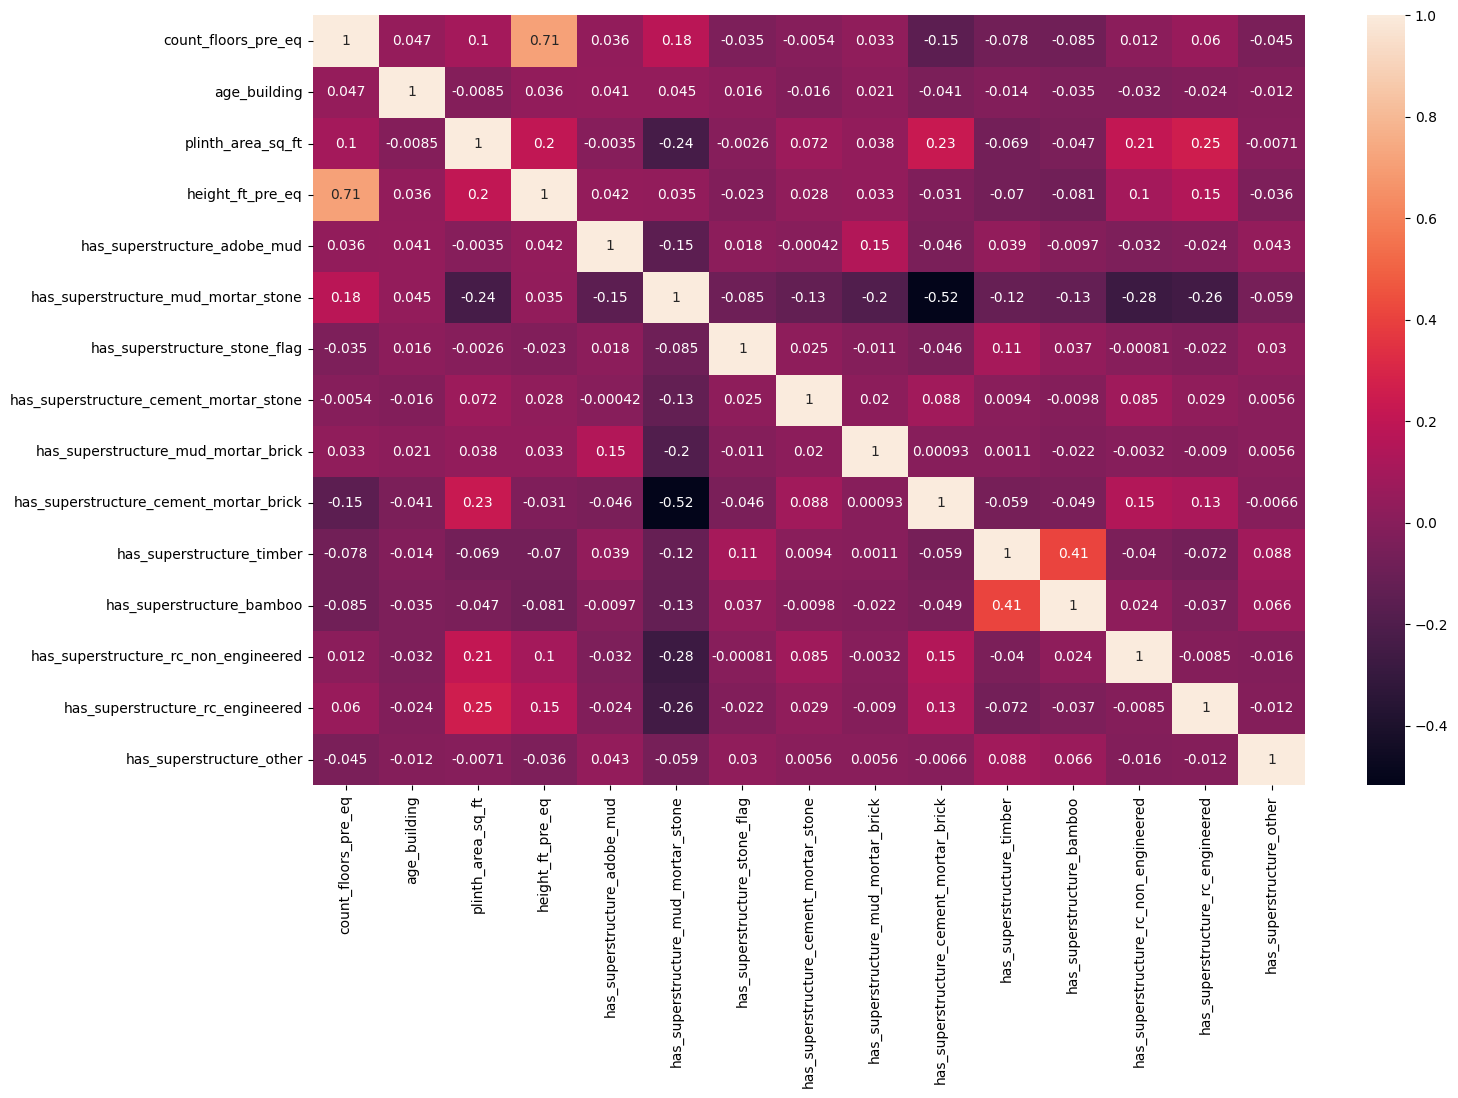

In [8]:
# Create correlation matrix
correlation = df.select_dtypes('number').drop(columns = 'target').corr()
# Plot heatmap of `correlation`
plt.figure(figsize = (16,10))
sns.heatmap(correlation, annot = True);

## Multicollinearity

* Floor count and height of building shows high collinearity
* Hence floor count is dropped
* Feature with less correlation with target should be dropped.
* But we will drop floor count rather than height.
* As there is not much difference between them.

In [9]:
# Checking collinearity with target 
print(df['target'].corr(df['count_floors_pre_eq']))
df['target'].corr(df['height_ft_pre_eq'])

0.16904872399965754


0.04911364038144871

## Variance Inflation Factor

| VIF Value	| Interpretation                   | Action                   |
|:---------:|:--------------------------------:|:------------------------:|
|1.0        | No multicollinearity	           | Good                     |
|1.0 – 5.0	| Moderate correlation, acceptable | Usually okay             |
|> 5.0	    | Potential multicollinearity	   | Inspect further          |
|> 10.0	    | Serious multicollinearity	       | Drop or combine features |


* As we can see all the VIF are in limits

In [10]:
# Calculating Variance Inflation Factor (VIF)
X = df.select_dtypes('number').drop(columns='target')
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = list(zip(X.columns, vif))
vif = pd.DataFrame(vif,columns = ('Features','VIF'))
vif['VIF'] = vif['VIF'].round(2)
vif

,Features,VIF
0,count_floors_pre_eq,22.21
1,age_building,1.15
2,plinth_area_sq_ft,4.58
3,height_ft_pre_eq,20.05
4,has_superstructure_adobe_mud,1.11
5,has_superstructure_mud_mortar_stone,6.23
6,has_superstructure_stone_flag,1.06
7,has_superstructure_cement_mortar_stone,1.04
8,has_superstructure_mud_mortar_brick,1.09
9,has_superstructure_cement_mortar_brick,1.38


In [11]:
# drop multicollinear column
df = df.drop(columns = 'count_floors_pre_eq')

## Building Height Distribution by Damage Severity

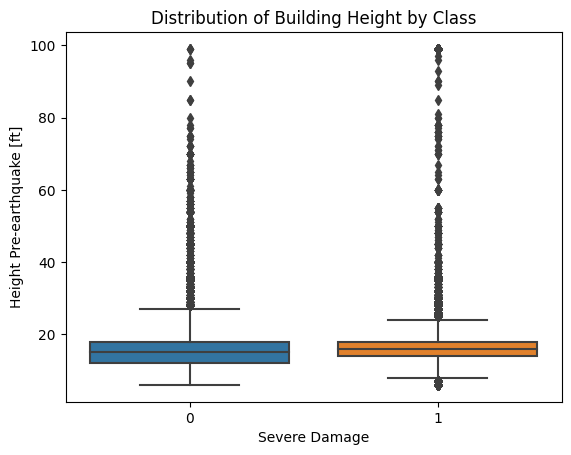

In [12]:
# Boxplot for Height of Building By Severe Damage 

sns.boxplot(x='target',y='height_ft_pre_eq',data=df)
plt.xlabel('Severe Damage')
plt.ylabel('Height Pre-earthquake [ft]')
plt.title('Distribution of Building Height by Class');

## Class Imbalance in Damage Labels

* **1** is for Severely Damaged
* **0** is for Not Severely Damaged

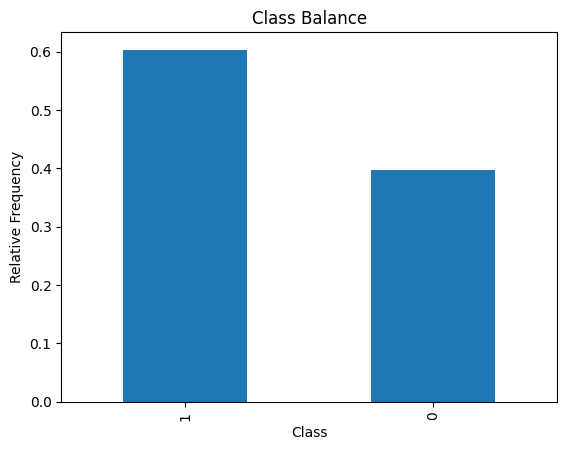

In [13]:
# Plot value counts of "severe_damage"
df['target'].value_counts(normalize = True).plot(
    kind='bar', xlabel='Class', ylabel='Relative Frequency',title='Class Balance'
);

## Damaged Probability across Foundation Type

* Proportion of building severely damaged is ~60%
* Proportion of building not severely damaged ~40%
* **Mud mortar-Stone/Brick** buildings have higher proportion of severely damaged buildings.
* **RC(Re-inforced Concrete)** buildings have lower proportion of severely damaged buildings.

 Majority class proportion[1]: 60.31%
 Minority class proportion[0]: 39.69% 



/tmp/ipykernel_13/1474215738.py:11: FutureWarning: The provided callable <function mean at 0x7bfc23ffbf60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  foundation_pivot = pd.pivot_table(


,Damaged Proportion
foundation_type,
RC,0.038263
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685115


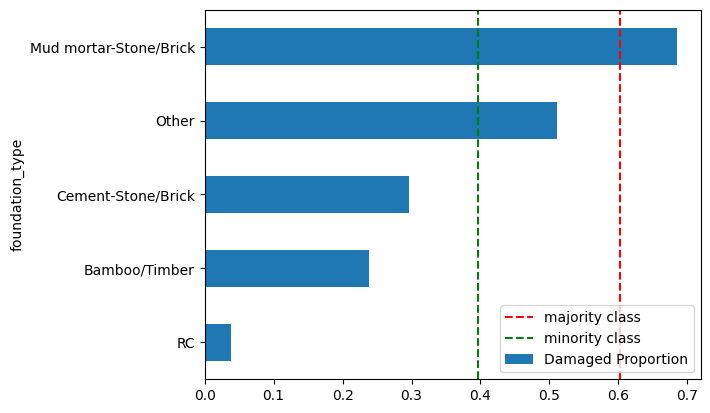

In [14]:
# Checking Majority and Minority Classes for damage

maj_prop, min_prop = df['target'].value_counts(normalize = True)

print(f' Majority class proportion[1]: {maj_prop:.2%}\
\n Minority class proportion[0]: {min_prop:.2%} \n')


# Create pivot table to access severely damaged building proportion among foundation type

foundation_pivot = pd.pivot_table(
    df, index='foundation_type', values='target', aggfunc=np.mean
).rename(columns={'target': 'Damaged Proportion'}
        ).sort_values(by='Damaged Proportion')

display(foundation_pivot)


# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind = 'barh',legend=None)

# Plot Vertical axis line for major and minor class
plt.axvline(maj_prop, linestyle='--',color ='red',label = 'majority class')

plt.axvline(min_prop, linestyle='--',color ='green',label = 'minority class')

plt.legend(loc='lower right');

# Logistic Regression Model

In [15]:
# Split Data to Train and Test set

X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.2, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (609675, 21)
y_train shape: (609675,)
X_test shape: (152419, 21)
y_test shape: (152419,)


## Baseline

In [16]:
# Calculating Baseline accuracy
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline,2))

Baseline Accuracy: 0.6


## Training Model

In [17]:
# seggregating columns for encoding and scaling

numeric_cols = ['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']

categorical_cols = ['land_surface_condition', 'foundation_type', 'roof_type',\
       'ground_floor_type', 'other_floor_type', 'position','plan_configuration']

binary_cols = [
    'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
    'has_superstructure_timber', 'has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
    'has_superstructure_other'
]

# preprocessing into ColumnTransformer for encoding and scaling
preprocessor = ColumnTransformer(transformers=[
    ('num',StandardScaler(),numeric_cols),
    ('cat',OneHotEncoder(),categorical_cols),
    ('bin','passthrough',binary_cols)
])

# making pipeline steps to train model
model = Pipeline(steps=[
    ('preprocessing',preprocessor),
    ('classifier',LogisticRegression(max_iter=1000))
])

# Fit and Train model with training data
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age_building',
                                                   'plinth_area_sq_ft',
                                                   'height_ft_pre_eq']),
                                                 ('cat', OneHotEncoder(),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration']),
                                                 ('bin', 'passthrough',
                                                  ['has_superstructure_adobe_mud'...
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstructure_bamboo',
                                                   'has_superstructure_rc_non_engineered',
                                                   'has_superstructure_rc_engineered',
                                                   'has_superstructure_other'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [18]:
# Calculating accuracy for train and test sets
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.73
Test Accuracy: 0.73


* **[0.34759396, 0.65240604] -> [1]** this shows that the model calculated **~35%** probability for **class[0]** and **~65%** probability for **class[1]**.
* Hence the model **predicted(>50%)** as **class[1]** or severly damaged class.
* By default the threshold is **50%** to classify target

In [19]:
# predicted probability for training and test sets 
print(model.predict(X_train)[:5])
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

print(model.predict(X_test)[:5])
y_test_pred_proba = model.predict_proba(X_test)
print(y_test_pred_proba[:5])

[1 1 1 0 1]
[[0.34759396 0.65240604]
 [0.23280067 0.76719933]
 [0.21181957 0.78818043]
 [0.53016091 0.46983909]
 [0.36726396 0.63273604]]
[1 1 1 0 1]
[[0.34620865 0.65379135]
 [0.33925868 0.66074132]
 [0.3618302  0.6381698 ]
 [0.64099321 0.35900679]
 [0.2849127  0.7150873 ]]


In [20]:
# getting all feature names and coefficients
categorical_features = list(model.named_steps['preprocessing']
                            .named_transformers_['cat']
                            .get_feature_names_out(categorical_cols)
                           )

numeric_features = numeric_cols
binary_features = binary_cols

features = numeric_features + categorical_features +  binary_features
coefficients = model.named_steps['classifier'].coef_[0]
features[:5],coefficients[:5]

(['age_building',
  'plinth_area_sq_ft',
  'height_ft_pre_eq',
  'land_surface_condition_Flat',
  'land_surface_condition_Moderate slope'],
 array([ 0.02726282, -0.04573164,  0.11072025, -0.21384054, -0.2661678 ]))

## Feature Impact with Odds Ratios 

Using the coefficients from our logistic regression model, we compute **odds ratios** to understand how each feature influences the likelihood of a building experiencing severe earthquake damage.

* Converted logistic regression **coefficients to odds** ratios for interpretability
* **Higher** odds ratio means **stronger** influence toward predicting **class[1]**
* Logistic regression **coefficients** are in **log-odds scale** by default.
* Applying **np.exp()** converts them to **odds ratios**, making them easier to interpret.
* **Odds ratio > 1** means the feature increases **likelihood** of **class 1(severely damaged)**; < 1 means it decreases it.


In [21]:
# calculating odds ratio
odds_ratios = pd.Series(np.exp(coefficients), index=features).sort_values()
odds_ratios.head()

has_superstructure_rc_engineered          0.238467
has_superstructure_cement_mortar_brick    0.301227
foundation_type_RC                        0.463689
foundation_type_Bamboo/Timber             0.520170
roof_type_RCC/RB/RBC                      0.521726
dtype: float64



* These bars show features with the **highest odds ratios** from the logistic regression model.
* An **odds ratio > 1** means the feature increases the likelihood of **predicting class 1 (severe damage)**.
* For example, buildings with **'has_superstructure_mud_mortar_stone'** are about **2.5x** more likely to be severely damaged.
* Features like **'plan_configuration_Square'** and certain foundation types also contribute to **higher** risk.
* These insights help identify **construction patterns** associated with **higher structural vulnerability**.

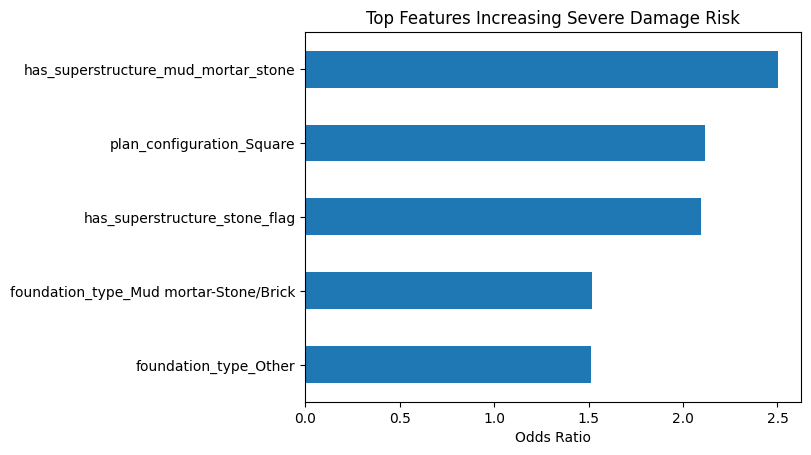

In [22]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind='barh')
plt.xlabel('Odds Ratio')
plt.title("Top Features Increasing Severe Damage Risk");

* These are features with **odds ratios < 1**, indicating they reduce the odds of severe damage.
* A **lower odds ratio** means the feature is **negatively associated** with **class 1 (severe damage)**.
* For example, an odds ratio of **0.5** means the feature **halves** the odds of severe damage.
* Such features may reflect safer **building materials, structures, or layouts**.
* These can be useful for guiding **disaster-resilient construction practices**.

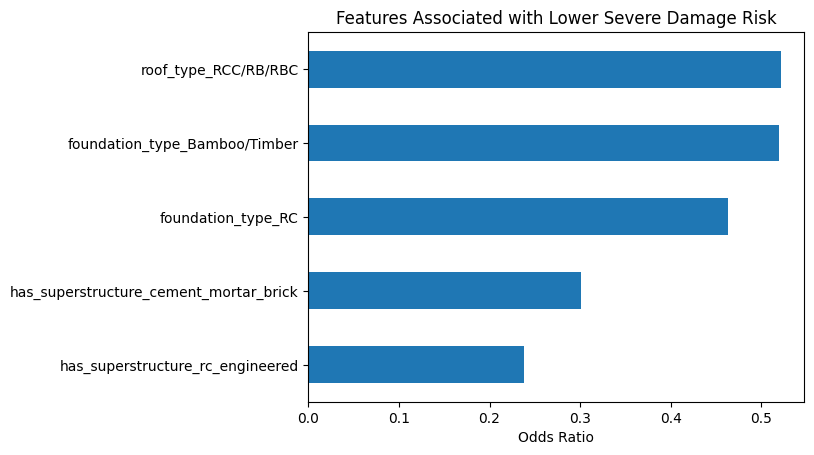

In [23]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind='barh')
plt.xlabel('Odds Ratio')
plt.title("Features Associated with Lower Severe Damage Risk");

## Metrics


#### Confusion Matrix
* True Negatives (TN): **25,419** -> correctly predicted class 0
* False Positives (FP): **35,346** -> predicted 1 when actual is 0
* False Negatives (FN): **5,815** -> predicted 0 when actual is 1
* True Positives (TP): **85,839** -> correctly predicted class 1

#### Evaluation Metrics
* **Accuracy (72.99%)**
  - Overall, how often the model is correct
  - Not always reliable for imbalanced datasets
* **Precision (70.83%)**
  - Of all predicted class 1, how many were actually class 1
  - Useful when false positives are costly
* **Recall (93.66%)**
  - Of all actual class 1, how many did we correctly identify
  - Critical when missing positives is risky (e.g., earthquake damage)
* **F1 Score (80.66%)**
  - Harmonic mean of Precision and Recall
  - Balanced metric for uneven class distribution
* **ROC-AUC Score (72.80%)**
  - How well the model separates class 0 and 1
  - AUC > 0.7 is considered a good classifier

Model Evaluation Metrics:
Accuracy     : 0.7299
Precision    : 0.7083
Recall       : 0.9366
F1 Score     : 0.8066
ROC-AUC Score: 0.7280


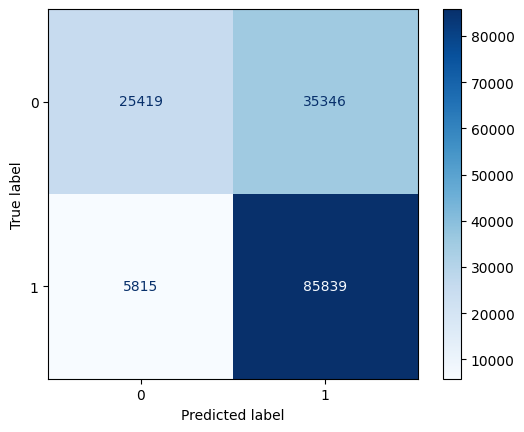

In [24]:
# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Classification metrics
print("Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision    : {precision_score(y_test, y_pred):.4f}")
print(f"Recall       : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score     : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues');


## ROC curve

* ROC Curve shows how well the classifier distinguishes between the classes at different thresholds.
* The blue line represents the performance of model.
* A curve above the diagonal indicates better-than-random classification.
* Model has an **AUC score** of **0.728**, meaning:
  - There's a **72.8%** chance that the model will rank a randomly chosen positive example higher than a negative one.
* The **closer** the curve hugs the **top-left** corner, the better the model is.
* **AUC = 1.0**: perfect classifier, **AUC = 0.5**: no discrimination ability.



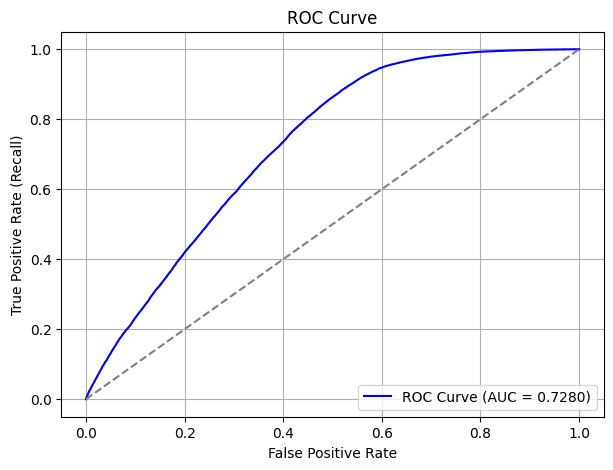

In [25]:
# Get predicted probabilities for class 1
y_proba = model.predict_proba(X_test)[:, 1]

# Step 2: Compute FPR, TPR for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Step 3: Plot the ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal (random guess)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
